In [1]:
!pip uninstall -y nvidia-physicsnemo fsspec s3fs
!pip install "fsspec==2025.3.0" "s3fs==2025.3.0" "gcsfs==2025.3.0" "jedi>=0.16"
!pip install --no-deps "nvidia-physicsnemo==1.2.0"
!pip install -U hydra-core==1.3.2 omegaconf==2.3.0
!pip install mlflow
!pip install nvidia-physicsnemo-sym --no-build-isolation
#!pip install --no-deps "nvidia-physicsnemo-sym==2.2.0"

Found existing installation: fsspec 2025.3.0
Uninstalling fsspec-2025.3.0:
  Successfully uninstalled fsspec-2025.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.0/806.0 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
!git clone https://github.com/heechangkim/physicsnemo_FNO_tutorial.git

Cloning into 'physicsnemo_FNO_tutorial'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 31 (delta 2), reused 14 (delta 1), pack-reused 16 (from 1)
Receiving objects: 100% (31/31), 47.41 MiB | 24.58 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
from hydra.utils import to_absolute_path
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra

In [5]:
%cd /content/physicsnemo_FNO_tutorial/Darcy_FNO/conf/
%mkdir /tmp/conf
%cp config_Burgers.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_Burgers"
cfg = compose(config_name=config_name)

/content/physicsnemo_FNO_tutorial/Darcy_FNO/conf
mkdir: cannot create directory ‘/tmp/conf’: File exists


In [18]:
from omegaconf import OmegaConf, open_dict
with open_dict(cfg):
    cfg.network_dir = "outputs"
    cfg.training.max_steps = 3000
print(OmegaConf.to_yaml(cfg))

training:
  max_steps: 1000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  grad_clip_max_norm: 0.5
  monitor_grad_clip: true
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
amp:
  enabled: false
  mode: per_order_scaler
  dtype: float16
  autocast_activation: false
  autocast_firstlayer: false
  default_max_scale_log2: 0
  custom_max_scales_log2: {}
graph:
  func_arch: true
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk
summary_histograms: 'off'
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: true
cud

In [7]:
from physicsnemo.sym.eq.pde import PDE
from numpy import pi
from sympy import Symbol, Eq, Abs, Number, Function
class CustomPDE(PDE):
    name = "BurgersEquation1D"
    def __init__(self, alpha = 0.01/pi):
        ## coordinates
        x = Symbol("x")
        ## time
        t = Symbol("t")

        ## Make input variables
        input_variables = {"t":t, "x":x}

        ## Make u function
        u = Function("u")(*input_variables)

        ## Coefficient alpha
        if type(alpha) is str:
            alpha = Function(alpha)(*input_variables)
        elif type(alpha) in [float, int]:
            alpha = Number(alpha)

        ## Set equations
        self.equations = {}
        self.equations["Burgers"] = (
            u.diff(t) + u*u.diff(x) - alpha*u.diff(x,2)
        ) ## "custom_pde" key name will be used in constraints

In [10]:
from physicsnemo.sym.key import Key
from physicsnemo.sym.hydra import to_absolute_path, instantiate_arch
from physicsnemo.sym.models.activation import Activation
from physicsnemo.sym.models.fully_connected import FullyConnectedArch
Burgers = CustomPDE(alpha = 0.01/pi)
u_net = FullyConnectedArch(
    input_keys=[Key("t"), Key("x")],
    output_keys=[Key("u")],
    nr_layers=8,
    layer_size=20,
    activation_fn=Activation.TANH,
)
nodes = Burgers.make_nodes() + [u_net.make_node(name="u_network")]

In [11]:
from physicsnemo.sym.geometry.primitives_1d import Line1D
## Make geometry
t, x = Symbol("t"), Symbol("x")

geo = Line1D(-1,1)
time_range = {t:(0,1)}

In [12]:
from physicsnemo.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)
from physicsnemo.sym.solver import Solver
from physicsnemo.sym.domain import Domain
from sympy import sin
domain = Domain()

## Initial Condition
IC = PointwiseInteriorConstraint(
    nodes = nodes,
    geometry = geo,
    outvar = {"u": -sin(pi*x)},
    batch_size = 300, ## What is the meaning of batch_size and cfg?
    parameterization={t:0.0},
    batch_per_epoch=1,
)
domain.add_constraint(IC,"IC")

## Boundary Condition
BC = PointwiseBoundaryConstraint(
    nodes = nodes,
    geometry= geo,
    outvar={"u":0},
    batch_size = 700,
    parameterization=time_range,
    batch_per_epoch=1,
)
domain.add_constraint(BC,"BC")

## Interior
interior = PointwiseInteriorConstraint(
    nodes = nodes,
    geometry = geo,
    outvar = {"Burgers":0},
    batch_size = 6000,
    parameterization=time_range,
    batch_per_epoch=1,
)
domain.add_constraint(interior, "interior")

In [16]:
import numpy as np
import scipy.io
%cd /content
data = scipy.io.loadmat('./burgers.mat')
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.transpose(np.real(data['usol']))
X, T = np.meshgrid(x,t)
X = X.flatten()[:,None]
T = T.flatten()[:,None]
u_star = Exact.flatten()[:,None]

/content


In [19]:
slv = Solver(cfg, domain)
## Start solver
slv.solve()

/usr/local/lib/python3.12/dist-packages/physicsnemo/sym/amp.py:219: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  super().__init__(*args, **kwargs)


In [20]:
u_net_star = FullyConnectedArch(
    input_keys=[Key("t"), Key("x")],
    output_keys=[Key("u")],
    nr_layers=8,
    layer_size=20,
    activation_fn=Activation.TANH,
)

In [26]:
import torch
u_net_star.load_state_dict(torch.load("outputs/u_network.0.pth"))
u_net_star.cuda()

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=2, out_features=20, bias=True)
      )
      (1-7): 7 x FCLayer(
        (linear): WeightNormLinear(in_features=20, out_features=20, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=20, out_features=1, bias=True)
    )
  )
)

In [27]:
input_ = {'t': torch.Tensor(T).cuda(),
          'x': torch.Tensor(X).cuda()}

In [28]:
output = u_net_star(input_)

In [30]:
output['u'].shape

torch.Size([25600, 1])

In [31]:
u_star.shape

(25600, 1)

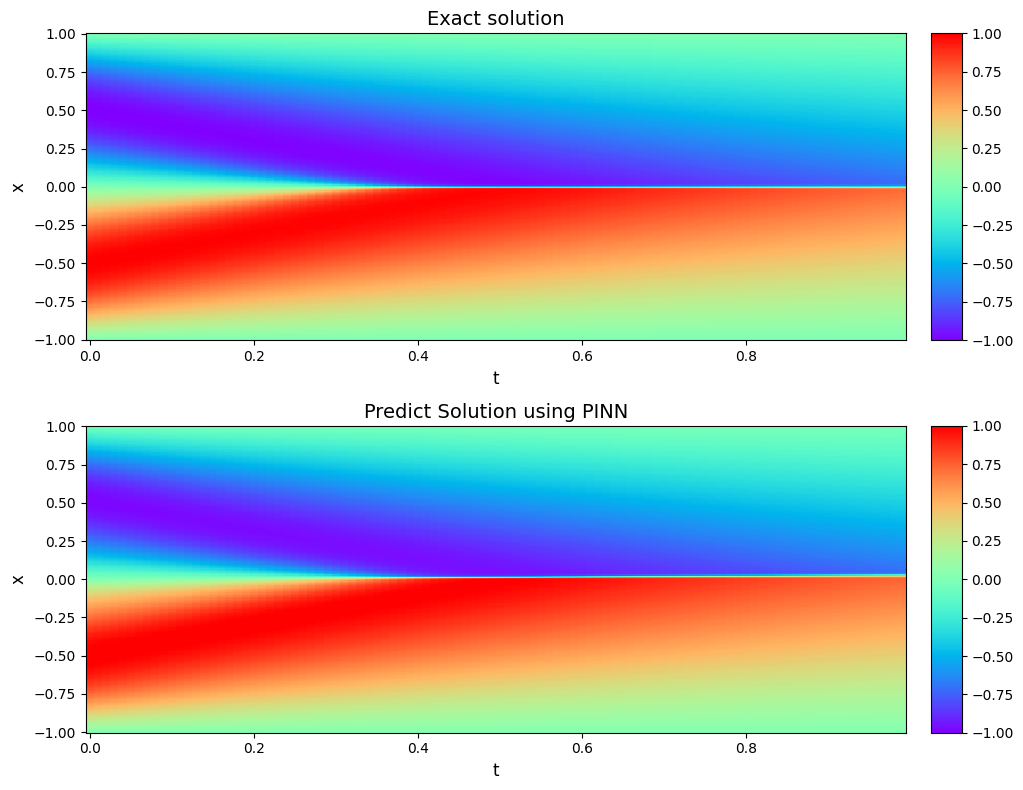

In [35]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
## Plot in 2D
x = X.reshape((100,256))
t = T.reshape((100,256))
u_star = u_star.reshape((100,256))

pred_u = output['u'].cpu().detach().numpy()
pred_u = pred_u.reshape((100,256))
fig = plt.figure(figsize=(11,8))
gs = GridSpec(2, 1)
## Plot Exact Solution
## X_star = (x_i, t_i) i = 1 to 25600 i.e. X_star.shape = (25600,2)
plt.subplot(gs[0,0])
plt.pcolormesh(t, x, u_star,cmap='rainbow')
plt.xlabel('t', fontsize = 12)
plt.ylabel('x', fontsize = 12)
plt.title('Exact solution', fontsize = 14)
cbar = plt.colorbar(pad=0.025, aspect=10)
#cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)

## Plot Predict Solution
plt.subplot(gs[1, 0])
plt.pcolormesh(t, x, pred_u, cmap='rainbow')
plt.xlabel('t', fontsize = 12)
plt.ylabel('x', fontsize = 12)
plt.title('Predict Solution using PINN', fontsize = 14)
cbar = plt.colorbar(pad=0.025, aspect=10)
#cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)
plt.tight_layout()
plt.show()